### 3-layer DCT-III StNN - Generator matrix encoded data

In [1]:
%reset -f
import gc
gc.collect()

0

In [2]:
global w0
global z0

w0 = 4
z0 = 3

n = 27
q = 7
num_samples = 1000

num_unseen_samples = 20

In [3]:
import numpy as np
import tensorflow as tf
import math

np.random.seed(42)

In [4]:
def next_power_of_two(x):
    return 2 ** math.ceil(math.log2(x))

n_padded = next_power_of_two(n)

x_original = np.random.randint(0, q, size=(num_samples, n))

padding = n_padded - n
dataset = np.pad(x_original, ((0, 0), (0, padding)), mode='constant', constant_values=0)

print(f"Original n: {n}, Padded to: {n_padded}")

Original n: 27, Padded to: 32


In [5]:
x_original.shape

(1000, 27)

In [6]:
dataset.shape

(1000, 32)

Encode using generator matrix
$$
\tilde{M}_{kj} = \left[ \left( \frac{w_0}{z_0} \right)^j \zeta^{kj} \right]_{k,j=0}^{n-1}
$$

In [7]:
def padded_generator_matrix(N, w0, z0):
    n = np.arange(N)
    k = n.reshape((N, 1))
    zeta = np.exp(-2j * np.pi / N)
    M_tilde = ((w0 / z0) ** n) * (zeta ** (k * n))
    return M_tilde

In [8]:
M_tilde = padded_generator_matrix(n_padded, w0, z0)
print(M_tilde.shape)

(32, 32)


In [9]:
encoded_dataset = np.array([np.dot(M_tilde, x) for x in dataset])
encoded_dataset[np.abs(encoded_dataset) < 1e-10] = 0
encoded_dataset = np.round(encoded_dataset, decimals=10)
encoded_dataset.shape

(1000, 32)

In [10]:
print(f"x_original[0]:", x_original[0])
print(f"\nAfter encoding:\n", encoded_dataset[0])

x_original[0]: [6 3 4 6 2 4 4 6 1 2 6 2 2 4 3 2 5 4 1 3 5 5 1 3 4 0 3]

After encoding:
 [18563.60052945    +0.j         -3175.07412411+14542.65392496j
 -9480.13851167 -1549.89213738j  -850.18419129 -5788.51248279j
  2813.63372348 -2457.36436449j  3312.0476391   +337.88077825j
  1059.2907911  +3489.68169028j -2366.82367016  +909.74502726j
  -210.29906943  +357.85181443j -3878.07651347  +373.95548592j
   -49.25036994 -6370.32567308j  6901.71964373 -1088.5938127j
  2896.76301761 +7252.43377368j -6714.83312544 +4427.90575271j
 -5496.28870703 -5330.43278044j  2828.24226801 -6162.17891893j
  6446.94186958    -0.j          2828.24226801 +6162.17891893j
 -5496.28870703 +5330.43278044j -6714.83312544 -4427.90575271j
  2896.76301761 -7252.43377368j  6901.71964373 +1088.5938127j
   -49.25036994 +6370.32567308j -3878.07651347  -373.95548592j
  -210.29906943  -357.85181443j -2366.82367016  -909.74502726j
  1059.2907911  -3489.68169028j  3312.0476391   -337.88077825j
  2813.63372348 +2457.36436449j

Pre-processing

In [11]:
N = encoded_dataset.shape[1]

k = np.arange(N)
shift = np.exp(-1j * np.pi * k / (2 * N))
alpha_k = np.where(k == 0, np.sqrt(1/N), np.sqrt(2/N))

dct2_dataset = np.array([np.real(alpha_k * shift * y) for y in encoded_dataset])
dct2_dataset[np.abs(dct2_dataset) < 1e-10] = 0
dct2_dataset = np.round(dct2_dataset, decimals=10) # Round for numerical stability

In [12]:
"""
The part below is for testing purposes only
"""

from scipy.fftpack import dct

dct3_dataset = np.array([dct(x, type=3, norm='ortho') for x in dct2_dataset])

X_perm = np.hstack((dct3_dataset[:, ::2], dct3_dataset[:, 1::2][:, ::-1]))

D_hat_n = np.array([(z0 / w0) ** k for k in range(N)])
decoded_dataset = X_perm * D_hat_n

# Print verification (for one sample)
sample_idx = 78
print("Original x:", dataset[sample_idx])
print("\nEncoded y:", encoded_dataset[sample_idx])
print("\nDCT Coefficients:", np.round(dct2_dataset[sample_idx], 4))
print("\nReconstructed Signal:", np.round(dct3_dataset[sample_idx], 4))
print("\nAfter Permutation:", np.round(X_perm[sample_idx], 4))
print("\nAfter Scaling:", np.round(decoded_dataset[sample_idx], 4))

Original x: [4 3 6 4 2 0 5 6 6 2 2 1 6 1 1 5 1 4 3 0 2 4 0 6 6 6 4 0 0 0 0 0]

Encoded y: [ 29916.11588021    +0.j            328.95686704+26422.4846445j
 -21936.20111033 +3988.95593508j  -7301.38988823-17810.36382931j
  13577.84642585 -8953.74117052j   9354.9421295  +8727.48732799j
  -4221.49645678 +8798.15590637j  -7861.90722461  -861.73832776j
   -779.76795929 -5322.56486315j   2168.22506293 -1740.90057156j
   1615.33333537 -1441.8771791j    5127.91361716 +2018.69510167j
  -2943.81135295 +6208.60576073j  -5262.87924206 -2070.18847016j
    798.8487054  -4460.7613612j    2679.94226354  +633.97975698j
   -477.22622529    -0.j           2679.94226354  -633.97975698j
    798.8487054  +4460.7613612j   -5262.87924206 +2070.18847016j
  -2943.81135295 -6208.60576073j   5127.91361716 -2018.69510167j
   1615.33333537 +1441.8771791j    2168.22506293 +1740.90057156j
   -779.76795929 +5322.56486315j  -7861.90722461  +861.73832776j
  -4221.49645678 -8798.15590637j   9354.9421295  -8727.48732799j
 

In [13]:
y = dataset.astype(np.float32)
y_normalized = y / (q - 1)  # Scale to [0, 1]

# labels = y
labels = y_normalized

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    dct2_dataset, labels, test_size=0.2, random_state=42
)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(800, 32) (800, 32)
(200, 32) (200, 32)


In [15]:
X_train = (X_train - X_train.mean()) / X_train.std()
X_test = (X_test - X_test.mean()) / X_test.std()

DCT-3 imposed StNN

In [16]:
class FirstLayer(tf.keras.layers.Layer):
    def __init__(self, units, trainable=True, **kwargs):
        super(FirstLayer, self).__init__(**kwargs)
        self.n = units
        self.n1 = units // 2
        self.trainable = trainable

        init_diag = tf.ones(self.n1, dtype=tf.float32)
        init_diag = tf.tensor_scatter_nd_update(init_diag, [[0]], [tf.sqrt(2.0)])

        self.B_1 = self.add_weight(
                shape=(self.n1,),
                initializer=tf.keras.initializers.Constant(init_diag),
                trainable=self.trainable,
                name='B_1'
            )
        self.B_2 = self.add_weight(
                shape=(self.n1,),
                initializer='ones',
                trainable=self.trainable,
                name='B_2'
            )
        self.bias = self.add_weight(
            shape=(self.n,),
            initializer='zeros',
            trainable=True,
            name='bias'
        )

    def call(self, x):
        even = x[:, ::2]
        odd = x[:, 1::2]

        d1 = tf.multiply(odd, self.B_1) # diagonal
        d2 = tf.multiply(tf.concat([tf.zeros_like(odd[:, :1]), odd[:, :-1]], axis=1), self.B_2) # off-diagonal
        B_n = tf.add(d1, d2)

        u = tf.concat([even, B_n], axis=1)

        return u + self.bias

In [17]:
class DCTIII(tf.keras.layers.Layer):
    def __init__(self, n, trainable=True, **kwargs):
        super(DCTIII, self).__init__(**kwargs)
        self.n = n
        self.n1 = n // 2 if n > 2 else 1
        self.trainable = trainable

        if n == 2:
            # Base case: trainable 2x2 matrix
            self.C_2 = self.add_weight(
                shape=(2, 2),
                initializer=tf.keras.initializers.Constant((1 / np.sqrt(2)) * np.array([[1., 1.], [1., -1.]])),
                trainable=self.trainable,
                name='C_2'
            )
        else:
            init_diag = tf.ones(self.n1, dtype=tf.float32)
            init_diag = tf.tensor_scatter_nd_update(init_diag, [[0]], [tf.sqrt(2.0)])

            # Weights for B^T_{n/2}
            self.B_1 = self.add_weight(
                shape=(self.n1,),
                initializer=tf.keras.initializers.Constant(init_diag),
                trainable=self.trainable,
                name='B_1'
            )
            self.B_2 = self.add_weight(
                shape=(self.n1,),
                initializer='ones',
                trainable=self.trainable,
                name='B_2'
            )

            k = tf.cast(tf.range(1, self.n1 + 1), tf.float32)
            pi = tf.constant(np.pi, dtype=tf.float32)
            init_W_c = 1 / (2 * tf.cos((2 * k - 1) * (pi / (2 * self.n))))

            # Weight for W_c
            self.w_c = self.add_weight(
                shape=(self.n1,),
                initializer=tf.keras.initializers.Constant(init_W_c),
                trainable=self.trainable,
                name='W_c'
            )

            # Recursive DCTIII for n/2
            self.dctiii_layer1 = DCTIII(self.n1,trainable=self.trainable)
            self.dctiii_layer2 = DCTIII(self.n1,trainable=self.trainable)

    def call(self, x):
        if self.n == 2:
            y = tf.matmul(self.C_2, x, transpose_b=True)
            return tf.transpose(y)
        else:
            # Permutation
            even = x[:, ::2]
            odd = x[:, 1::2]

            # B^T
            d1 = tf.multiply(odd, self.B_1)
            d2 = tf.multiply(tf.concat([tf.zeros_like(odd[:, :1]), odd[:, :-1]], axis=1), self.B_2)
            B_n = tf.add(d1, d2)
            u = tf.concat([even, B_n], axis=1)

            # Recursive DCTIII
            z1 = self.dctiii_layer1(u[:, :self.n1])
            z2 = self.dctiii_layer2(u[:, self.n1:])
            recurs_out = tf.concat([z1, z2], axis=1)

            # W_c
            W_n = tf.multiply(recurs_out[:, self.n1:], self.w_c)
            v = tf.concat([recurs_out[:, :self.n1], W_n], axis=1)

            # H_n
            out1 = v[:, :self.n1]
            out2 = v[:, self.n1:]
            y = (1 / tf.sqrt(tf.constant(2.0, dtype=tf.float32))) * tf.concat(
                [(out1 + out2), tf.reverse((out1 - out2), axis=[1])],
                axis=1
            )

            return y

In [18]:
class SecondLayer(tf.keras.layers.Layer):
    def __init__(self, units, trainable=True, **kwargs):
        super(SecondLayer, self).__init__(**kwargs)
        self.n = units
        self.n1 = units // 2
        self.trainable = trainable

        self.bias = self.add_weight(
            shape=(self.n,),
            initializer='zeros',
            trainable=True,
            name='bias'
        )

        # Recursive DCTIII for n/2
        self.dctiii1 = DCTIII(self.n1, trainable=self.trainable)
        self.dctiii2 = DCTIII(self.n1,trainable=self.trainable)

    def call(self, x):
        z1 = self.dctiii1(x[:, :self.n1])
        z2 = self.dctiii2(x[:, self.n1:])
        out = tf.concat([z1, z2], axis=1)
        return out + self.bias

In [19]:
class ThirdLayer(tf.keras.layers.Layer):
    def __init__(self, units, trainable=True, **kwargs):
        super(ThirdLayer, self).__init__(**kwargs)
        self.n = units
        self.n1 = units // 2
        self.trainable = trainable

        k = tf.cast(tf.range(1, self.n1 + 1), tf.float32)
        pi = tf.constant(np.pi, dtype=tf.float32)
        init_W_c = 1 / (2 * tf.cos((2 * k - 1) * (pi / (2 * self.n))))

        self.w_c = self.add_weight(
                shape=(self.n1,),
                initializer=tf.keras.initializers.Constant(init_W_c),
                trainable=self.trainable,
                name='W_c'
            )

        self.bias = self.add_weight(
            shape=(self.n,),
            initializer='zeros',
            trainable=True,
            name='bias'
        )

    def call(self, x):
        input1 = x[:, :self.n1]
        input2 = x[:, self.n1:]

        # W_{N/2}
        W_n = tf.multiply(input2, self.w_c)
        v = tf.concat([input1, W_n], axis=1)

        # H_n^T
        out1 = v[:, :self.n1]
        out2 = v[:, self.n1:]

        y = (1 / tf.sqrt(tf.constant(2.0, dtype=tf.float32))) * tf.concat([(out1 + out2), tf.reverse((out1 - out2), axis=[1])], axis=1)

        return y + self.bias

In [20]:
class DiagonalLayer(tf.keras.layers.Layer):
    def __init__(self, units, trainable=True, kernel_initializer='he_normal', bias_initializer='zeros', **kwargs):
        super(DiagonalLayer, self).__init__(**kwargs)
        self.units = units
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.trainable = trainable

    def build(self, input_shape):
        self.diag = self.add_weight(
            shape=(self.units,),
            initializer=tf.keras.initializers.get(self.kernel_initializer),
            trainable=self.trainable,
            name='diag'
        )
        self.bias = self.add_weight(
            shape=(self.units,),
            initializer=tf.keras.initializers.get(self.bias_initializer),
            trainable=self.trainable,
            name='bias'
        )

    def call(self, inputs):
        scaled = tf.multiply(inputs, self.diag)
        return scaled + self.bias

In [21]:
class ScalingLayer(tf.keras.layers.Layer):
    def __init__(self, units, initial_scale=1.0, trainable=True, kernel_initializer='he_normal', bias_initializer='zeros', **kwargs):
        super(ScalingLayer, self).__init__(**kwargs)
        self.units = units
        self.initial_scale = initial_scale
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer

    def build(self, input_shape):

      self.log_scale = self.add_weight(
          shape=(),
          initializer=tf.keras.initializers.Constant(self.initial_scale),
          trainable=True,
          name="log_scale",
      )
      self.diag = self.add_weight(
          shape=(self.units,),
          initializer=tf.keras.initializers.get(self.kernel_initializer),
          regularizer=tf.keras.regularizers.l2(1e-4),
          trainable=True,
          name='diag'
      )
      self.bias = self.add_weight(
          shape=(self.units,),
          initializer=tf.keras.initializers.get(self.bias_initializer),
          trainable=True,
          name='bias'
        )

      super().build(input_shape)

    def call(self, inputs):
      perm = tf.concat([inputs[:, ::2], inputs[:, 1::2][:, ::-1]], axis=-1)

      dim = tf.shape(perm)[1]

      D_hat_n = tf.exp(self.log_scale * tf.cast(tf.range(dim), tf.float32))

      scaled = perm * D_hat_n * self.diag

      return scaled + self.bias

Model

In [22]:
def custom_accuracy(y_true, y_pred):
    y_true_int = tf.cast(y_true*(q-1), tf.int32)
    y_pred_int = tf.cast(tf.round(y_pred*(q-1)), tf.int32)
    correct = tf.cast(tf.equal(y_true_int, y_pred_int), tf.float32)
    return tf.reduce_mean(correct)

def custom_accuracy_without_padding(y_true, y_pred):
    y_true_int = tf.cast(y_true * (q - 1), tf.int32)
    y_pred_int = tf.cast(tf.round(y_pred * (q - 1)), tf.int32)
    mask = tf.concat(
        [tf.ones((tf.shape(y_true)[0], n), dtype=tf.float32),
         tf.zeros((tf.shape(y_true)[0], n_padded - n), dtype=tf.float32)],
        axis=1
    )
    correct = tf.cast(tf.equal(y_true_int, y_pred_int), tf.float32) * mask
    return tf.reduce_sum(correct) / tf.reduce_sum(mask)

def custom_mse(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    loss = tf.reduce_mean(tf.square(tf.cast(y_true - y_pred, tf.float32)))
    return loss

In [23]:
from tensorflow.keras.layers import InputLayer, LeakyReLU, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

initial_log_scale = np.log(z0 / w0)
initial_scale = (z0 / w0)

input_shape = (n_padded,)
model = Sequential([
    InputLayer(shape=input_shape),
    FirstLayer(units=n_padded, trainable=True, name="first_layer"),
    # LeakyReLU(negative_slope=0.1),
    SecondLayer(units=n_padded, trainable=True, name="second_layer"),
    # LeakyReLU(negative_slope=0.1),
    ThirdLayer(units=n_padded, trainable=True, name="third_layer"),
    LeakyReLU(negative_slope=0.1),
    ScalingLayer(units=n_padded, initial_scale=initial_log_scale, trainable=True, kernel_initializer='ones', bias_initializer='zeros', name="scaling_layer"),
    LeakyReLU(negative_slope=0.1)
    # DiagonalLayer(units=n_padded, trainable=False, kernel_initializer='ones', bias_initializer='zeros', name="output_layer"),
    # Activation('linear')
])

# notes:
# 1. adding the diagonal layers in the middle worsens results
# 2. residual connections does not work
# 3. removing bias in hidden layers worsens performance
# 4. removing "LeakyReLU" activation in between layers improved performance


model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=custom_mse,
    metrics=[custom_mse, custom_accuracy_without_padding]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ first_layer (FirstLayer)        │ (None, 32)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ second_layer (SecondLayer)      │ (None, 32)             │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ third_layer (ThirdLayer)        │ (None, 32)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ scaling_layer (ScalingLayer)    │ (None, 32)             │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 417 (1.63 KB)

 Trainable params: 417 (1.63 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# ------------- FLOP counts ---------------

# Create concrete function
input_shape = (1, n_padded)  # batch size 1
concrete_func = tf.function(model).get_concrete_function(tf.TensorSpec(input_shape, tf.float32))

from tensorflow.python.profiler import model_analyzer
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder

profile_opts = ProfileOptionBuilder.float_operation()
flops = model_analyzer.profile(concrete_func.graph, options=profile_opts)

print('FLOPs:', flops.total_float_ops)

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


FLOPs: 879


Training

In [25]:
# from google.colab import drive
# drive.mount('/content/drive')

In [26]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

checkpoint_path = f"/content/drive/MyDrive/10 Masters/Research/error-correcting-codes/ThisIsTheCleanest/weights/DCT_model_{n}.keras"

model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

adjust_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[adjust_lr, early_stopping, model_checkpoint]
)

Epoch 1/500
14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - custom_accuracy_without_padding: 0.1410 - custom_mse: 0.2891 - loss: 0.2923  
Epoch 1: val_loss improved from inf to 0.24405, saving model to /content/drive/MyDrive/10 Masters/Research/error-correcting-codes/ThisIsTheCleanest/weights/DCT_model_27.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 123ms/step - custom_accuracy_without_padding: 0.1408 - custom_mse: 0.2846 - loss: 0.2878 - val_custom_accuracy_without_padding: 0.1472 - val_custom_mse: 0.2400 - val_loss: 0.2440 - learning_rate: 0.0010
Epoch 2/500
14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - custom_accuracy_without_padding: 0.1426 - custom_mse: 0.2435 - loss: 0.2467 
Epoch 2: val_loss improved from 0.24405 to 0.21099, saving model to /content/drive/MyDrive/10 Masters/Research/error-correcting-codes/ThisIsTheCleanest/weights/DCT_model_27.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - custom_accuracy_without_padding: 0.1417 - custom_mse: 0.2394 - loss: 0.2426 - val_custom_accuracy_without_pad

In [27]:
# Evaluate the model on the test set
eval_results = model.evaluate(X_test, y_test)
print(f"Test results - Loss: {eval_results[0]}, MSE: {eval_results[1]}, Accuracy: {eval_results[2]}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - custom_accuracy_without_padding: 0.7080 - custom_mse: 0.0267 - loss: 0.0281 
Test results - Loss: 0.028610995039343834, MSE: 0.027216032147407532, Accuracy: 0.70634925365448


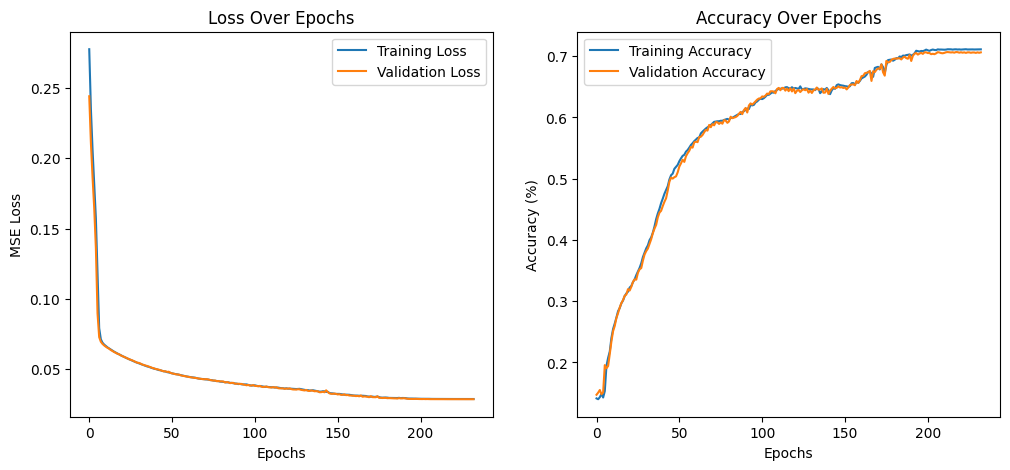

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['custom_accuracy_without_padding'], label='Training Accuracy')
plt.plot(history.history['val_custom_accuracy_without_padding'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

In [29]:
y_pred = model.predict(X_test)
y_test_rescaled = y_test * (q - 1)
y_pred_rescaled = y_pred * (q - 1)

print("Comparison of predictions and ground truth:")
for i in range(3):
    print(f"Sample {i+1}:")
    print(f"  Predicted:    {np.round(y_pred_rescaled[i]).astype(int)}")
    print(f"  Ground Truth: {np.round(y_test_rescaled[i]).astype(int)}")
    print("-" * 40)

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 282ms/step
Comparison of predictions and ground truth:
Sample 1:
  Predicted:    [3 3 3 3 3 3 3 3 4 2 3 1 4 0 3 2 5 1 4 3 4 4 6 5 2 3 1 0 0 0 0 0]
  Ground Truth: [5 6 5 1 3 4 1 1 6 2 3 1 4 0 3 2 5 1 4 3 4 4 6 5 2 3 1 0 0 0 0 0]
----------------------------------------
Sample 2:
  Predicted:    [3 3 3 3 3 3 3 3 3 2 4 3 3 1 3 1 1 2 0 1 1 5 2 1 4 0 4 0 0 0 0 0]
  Ground Truth: [1 4 1 3 3 3 0 5 5 2 4 3 3 1 3 1 1 2 0 1 1 5 2 1 4 0 4 0 0 0 0 0]
----------------------------------------
Sample 3:
  Predicted:    [3 3 3 3 3 3 3 3 3 6 4 1 0 5 2 3 5 1 4 6 0 4 3 2 3 4 4 0 0 0 0 0]
  Ground Truth: [2 6 0 2 2 1 3 4 2 6 4 1 0 5 2 3 5 1 4 6 0 4 3 2 3 4 4 0 0 0 0 0]
----------------------------------------


In [30]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)

print(f"R² Score: {r2:.4f}")

R² Score: 0.5993


In [31]:
# ---------------------- Inference time on Test Set ----------------------------

import time

_ = model.predict(X_test, verbose=0)  # warm up

times = []
for _ in range(100):
    start = time.perf_counter()
    _ = model.predict(X_test, verbose=0)
    end = time.perf_counter()
    times.append(end - start)

average_inference_time = np.mean(times)
print(f"Average batch inference time over 100 runs: {average_inference_time:.6f} seconds")

average_per_sample = average_inference_time / X_test.shape[0]
print(f"Average inference time per sample (from batch): {average_per_sample:.6f} seconds")

Average batch inference time over 100 runs: 0.085681 seconds
Average inference time per sample (from batch): 0.000428 seconds


Test on unseen samples

In [32]:
# --------------------- Predictions on unseen samples (no noise) -------------------------

np.random.seed(42)

x_unseen_original = np.random.randint(0, q, size=(num_unseen_samples, n))
x_unseen_original_padded = np.pad(x_unseen_original, ((0, 0), (0, padding)), mode='constant', constant_values=0)

# encode
encoded_dataset_unseen = np.array([np.dot(M_tilde, x) for x in x_unseen_original_padded])
encoded_dataset_unseen[np.abs(encoded_dataset_unseen) < 1e-10] = 0
encoded_dataset_unseen = np.round(encoded_dataset_unseen, decimals=10)

# pre-process
N = encoded_dataset_unseen.shape[1]
k = np.arange(N)
shift = np.exp(-1j * np.pi * k / (2 * N))
alpha_k = np.where(k == 0, np.sqrt(1/N), np.sqrt(2/N))

x_unseen_dct2 = np.array([np.real(alpha_k * shift * y) for y in encoded_dataset_unseen])
x_unseen_dct2[np.abs(x_unseen_dct2) < 1e-10] = 0
x_unseen_dct2 = np.round(x_unseen_dct2, decimals=10)

# Normalize
x_unseen_dct2_normalized = (x_unseen_dct2 - x_unseen_dct2.mean()) / x_unseen_dct2.std()

# Predict
nn_pred = model.predict(x_unseen_dct2_normalized)

# Rescale prediction
y_pred_final = np.mod(np.round(nn_pred * (q - 1)), q)

# Evaluate
x_unseen_original_padded_normalized = x_unseen_original_padded.astype(np.float32) / (q - 1)

mse_nn = custom_mse(x_unseen_original_padded_normalized, nn_pred)
acc_nn = custom_accuracy_without_padding(x_unseen_original_padded_normalized, nn_pred)

print(f"MSE on unseen data (no noise): {mse_nn}")
print(f"Accuracy on unseen data (no noise): {acc_nn}")

num_display_samples = 3
for i in range(num_display_samples):
    print(f"\nSample {i+1}:")
    print(f"Original : {x_unseen_original_padded[i]}")
    print(f"NN Pred  : {y_pred_final[i].astype(int)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
MSE on unseen data (no noise): 0.02804783545434475
Accuracy on unseen data (no noise): 0.7240740656852722

Sample 1:
Original : [6 3 4 6 2 4 4 6 1 2 6 2 2 4 3 2 5 4 1 3 5 5 1 3 4 0 3 0 0 0 0 0]
NN Pred  : [3 3 3 3 3 3 3 4 2 2 6 2 2 4 3 2 5 4 1 3 5 5 1 3 4 0 3 0 0 0 0 0]

Sample 2:
Original : [1 5 4 3 0 0 2 2 6 1 3 3 6 5 5 6 5 2 3 6 3 0 2 4 2 6 4 0 0 0 0 0]
NN Pred  : [3 3 3 3 3 3 3 3 4 1 3 3 6 5 5 6 5 2 3 6 3 0 2 4 2 6 4 0 0 0 0 0]

Sample 3:
Original : [0 6 1 3 0 3 5 1 1 0 1 4 1 3 3 6 3 6 3 4 6 2 5 0 3 1 3 0 0 0 0 0]
NN Pred  : [3 3 3 3 3 3 3 3 2 0 1 4 1 3 3 6 3 6 3 4 6 2 5 0 3 1 3 0 0 0 0 0]


Visualize and Analyse model training

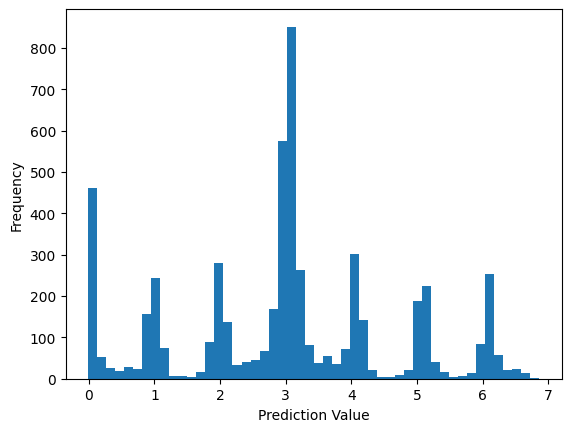

In [33]:
import matplotlib.pyplot as plt

# exclude zero pads
y_pred_first_n = y_pred[:, :n]
y_pred_first_n_rescaled = y_pred_first_n * (q - 1)

plt.hist(y_pred_first_n_rescaled.flatten(), bins=50)
plt.xlabel('Prediction Value')
plt.ylabel('Frequency')
plt.show()

In [34]:
for layer in model.layers:
    if layer.trainable_variables:  # Check if the layer has trainable variables
        for i, var in enumerate(layer.trainable_variables):
            print(f"{layer.name} - Variable {i} ({var.name}): values: {var.numpy()}")
    else:
        print(layer.name, "has no trainable variables.")

first_layer - Variable 0 (B_1): values: [1.5561031  1.0394279  1.0198071  1.0376966  1.0689796  1.0285695
 1.0283196  1.0532882  1.1130885  1.044472   1.0552671  1.0417613
 1.0421053  1.0130528  1.0219221  0.98595995]
first_layer - Variable 1 (B_2): values: [1.        1.0211439 1.0210642 1.012297  1.0583156 1.0247804 1.0275217
 1.0342069 1.1126189 1.032289  1.0522546 1.0487734 1.0300497 1.0167152
 1.0625889 1.0240319]
first_layer - Variable 2 (bias): values: [-0.09207391  0.1501484   0.05169125 -0.0434231   0.06073827 -0.03971915
  0.04764811  0.02328169  0.01975318  0.03037049  0.08724931  0.04884379
  0.07440558  0.10769667  0.04336534  0.20497727  0.16652326  0.078518
 -0.03521883 -0.01064933  0.01385808 -0.00510258 -0.0002807   0.01320645
 -0.00039699  0.00660742  0.0395695  -0.01657682  0.00656039  0.0186419
 -0.01989573 -0.00726046]
second_layer - Variable 0 (bias): values: [ 0.06444757  0.07991391  0.07242238  0.05728069  0.07869647  0.05889288
  0.04937721  0.05667206  0.054474

In [35]:
from tensorflow.keras import backend as K
K.clear_session()